# Training a Diffusion Model on 2-D Points

In this notebook, you'll learn how to train a diffusion model to generate spirals of 2-D points.

We'll explore the different components of diffusion models and their functions, as well as compare the quality of generated results using different model architectures. 

In [1]:
from dataclasses import dataclass
import math
from typing import Dict, Tuple

from matplotlib import pyplot as plt
from sklearn.datasets import make_swiss_roll
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# The Data

First, let's take a look at the data we'll be working with. Diffusion models can be very resource intensive when trained on images and videos, so in order for us to train on a CPU quickly, we'll start off by using a dataset of spirals in 2 dimensions.

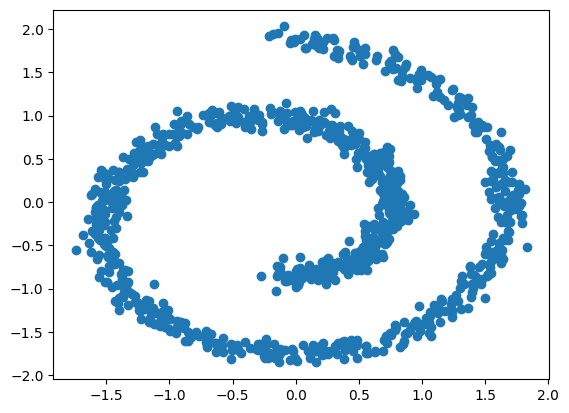

In [2]:
x, _ = make_swiss_roll(n_samples=1000, noise=0.5)
x = x[:, [0, 2]]
x = (x - x.mean()) / x.std()
plt.scatter(x[:, 0], x[:, 1])

## Dataloaders

Before training the model, we need to define some hyperparameters and create our train and validation dataloaders.

In [3]:
device = torch.device("cpu")

@dataclass
class TrainingConfig:
    batch_size: int = 256 # batch size
    learning_rate: float = 5e-4 # initial learning rate
    weight_decay: float = 1e-6 # weight decay
    num_denoising_steps: int = 1000 # number of timesteps


def load_data(config: TrainingConfig) -> Tuple[DataLoader, DataLoader]:
    """
    Load the data and return the train and validation dataloaders.

    Args:
      config: TrainingConfig object.
    Returns:
      train_dataloader: DataLoader for the training data.
      val_dataloader: DataLoader for the validation data.
    """
    n = int(1e+6)
    x, _ = make_swiss_roll(n_samples=n, noise=0)
    x = x[:, [0, 2]]
    scaling = 2
    x = (x - x.mean()) / x.std() * scaling
    x_train = x[:int(n * 0.8), :]
    x_val = x[int(n * 0.8):, :]

    class SimpleDataset:
      def __init__(self, data):
        self.data = data

      def __len__(self):
        return len(self.data)

      def __getitem__(self, i):
        return self.data[i]

    train_dataset = SimpleDataset(x_train)
    val_dataset = SimpleDataset(x_val)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

    return train_dataloader, val_dataloader


config = TrainingConfig()
train_dataloader, val_dataloader = load_data(config)
first_batch = next(iter(train_dataloader))
print("batch shape:", first_batch.shape)

batch shape: torch.Size([256, 2])


# The Models

Now it's time to define the models. We will define three separate models for the sake of comparison, where the difference between them is in how the information about the current timestep is integrated into the model's architecture.

- Model 1: Time Embedding Concatination
- Model 2: Sinusoidal Time Embedding Concatination
- Model 3: Sinusoidal Time Embedding Muliplication

### Model 1: Timestep Concatination 

Our first model is a simple three layer MLP. Note that in the `foward` method, we concatinate the time to the input before each foward pass. This allows the model to have a sense of the where it is in the denoising process.

In [4]:
class Model1(nn.Module):
    def __init__(self, hidden_features: list[int]):
        super().__init__()
        
        layers = []
        input_dim = 3  # The input dimension (t and x combined)
        
        for hidden_dim in hidden_features:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(input_dim, 2))
        layers.append(nn.Tanh())
        
        self.net = nn.Sequential(*layers)

    def forward(self, t, x):
        t = t / 1000.
        t = t.reshape(-1, 1)
        return self.net(torch.cat([t, x], 1))

# Example usage
hidden_dimensions = [512, 512]  # Example list of hidden dimensions
device = "cuda" if torch.cuda.is_available() else "cpu"
model1 = Model1(hidden_dimensions).to(device)

print(f"Model parameters: {sum(p.numel() for p in model1.parameters())}")


Model parameters: 265730


### Model 2: Sinusoidal Time Embedding Concatination

In this model, we utilize a 3-layer MLP. Instead of concatenating the raw time embedding directly to the image embedding, we first transform the time embedding into a sinusoidal embedding and then concatenate it with the image embedding.

**History**

This model builds upon the idea of incorporating temporal information into the embedding space, inspired by the effectiveness of sinusoidal embeddings in positional encoding for transformers. The sinusoidal representation allows the model to capture periodicity and smooth transitions in the time domain, potentially improving its ability to generalize across different temporal contexts.

In [5]:
class MLP(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: list[int],
    ):
        layers = []

        for a, b in zip(
            (in_features, *hidden_features),
            (*hidden_features, out_features),
        ):
            layers.extend([nn.Linear(a, b), nn.ELU()])

        super().__init__(*layers[:-1])


class Model2(nn.Module):
    def __init__(self, features: int, freqs: int = 16, **kwargs):
        super().__init__()

        self.net = MLP(2 * freqs + features, features, **kwargs)

        self.register_buffer('freqs', torch.arange(1, freqs + 1) * torch.pi)

    def forward(self, t, x):
        t = t / 1000.
        t = self.freqs * t[..., None]
        t = torch.cat((t.cos(), t.sin()), dim=-1)
        t = t.expand(*x.shape[:-1], -1)

        return self.net(torch.cat((t, x), dim=-1))


model2 = Model2(features=2, hidden_features=[512, 512]).to(device)
print(f"model params: {sum(p.numel() for p in model2.parameters())}")

model params: 281602


### Model 3: Sinusoidal Time Embeddings Multiplication

Model 3 introduces a time-conditioned architecture where time is incorporated directly into the network through TimeLinear layers. Instead of directly concatenating time embeddings with the image embeddings, the model uses the time embeddings to modulate the weights of the linear transformations dynamically. This approach allows the network to adapt its behavior to different timesteps, enabling more nuanced temporal modeling. 

In [6]:
class TimeEmbedding(nn.Module):
    """
    Time embedding module that embeds the time step into a hidden representation.
    Args:
        hidden_size: the size of the hidden representation.
        frequency_embedding_size: the size of the frequency embedding
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor):
        """Forward pass of the module."""

        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class TimeLinear(nn.Module):
    """
    Time linear layer that applies a linear transformation with time-dependent weights.
    """

    def __init__(self, dim_in: int, dim_out: int, num_timesteps: int):
        """
        Args:
            dim_in: the number of input features.
            dim_out: the number of output features.
            num_timesteps: the number of timesteps.
        """
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.num_timesteps = num_timesteps

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)
        return alpha * x


class Model3(nn.Module):
    def __init__(
        self, hidden_features: list[int], num_timesteps: int, dim_in:int = 2, dim_out:int = 2,
    ):
        super().__init__()
        """
        Build a noise estimating network.

        Args:
            hidden_features: dimensions of hidden features
            num_timesteps: number of timesteps
            dim_in: dimension of input
            dim_out: dimension of output
        """

        layers = []
        dims = [dim_in] + hidden_features

        # Build MLP layers with time-dependent linear layers
        for i in range(len(dims)-1):
            layers.append(TimeLinear(dims[i], dims[i+1], num_timesteps))
            layers.append(nn.ReLU())

        # Final layer to output noise prediction
        layers.append(TimeLinear(dims[-1], dim_out, num_timesteps))

        self.net = nn.Sequential(*layers)
        self.num_timesteps = num_timesteps


    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
            x: the noisy data after t period diffusion
            t: the time that the forward diffusion has been running
        """
        for layer in self.net:
            if isinstance(layer, TimeLinear):
                x = layer(x, t)
            else:
                x = layer(x)
        ######################
        return x


model3 = Model3(
    dim_in=2,
    dim_out=2,
    hidden_features=[512, 512],
    num_timesteps=config.num_denoising_steps,
).to(device)
print(f"model params: {sum(p.numel() for p in model3.parameters())}")

model params: 1054218


# Noise schedule

Here we create our noise shedule for the diffusion process, which controls how noise is added to the data across timesteps during forward difffusion. The schedule is parametized by $\beta_{min}$ and $\beta_{max}$ which define the range of noise intensity values.

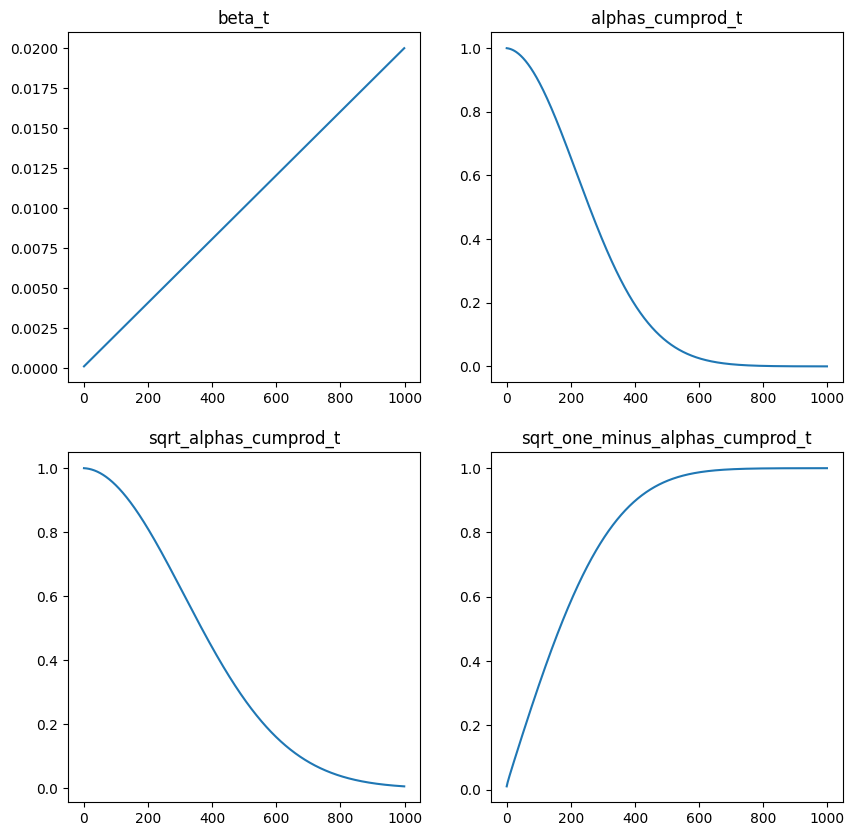

In [7]:
beta_min, beta_max = 1e-4, 0.02
# beta_min, beta_max = 1e-4, 1
# beta_min, beta_max = 0, 0.02

def create_noise_schedule(n_T: int, device: torch.device) -> Dict[str, torch.Tensor]:
    betas = torch.linspace(beta_min, beta_max, n_T).to(device)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0).to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1).to(device), alphas_cumprod[:-1].to(device)])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "betas": betas,
        "alphas_cumprod": alphas_cumprod,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance,
    }


noise_schedule = create_noise_schedule(config.num_denoising_steps, device)

# plot the schedule
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.plot(range(1000), noise_schedule["betas"].cpu().numpy())
plt.title("beta_t")

plt.subplot(2, 2, 2); plt.plot(range(1000), noise_schedule["alphas_cumprod"].cpu().numpy())
_ = plt.title("alphas_cumprod_t")

plt.subplot(2, 2, 3); plt.plot(range(1000), noise_schedule["sqrt_alphas_cumprod"].cpu().numpy())
plt.title("sqrt_alphas_cumprod_t")

plt.subplot(2, 2, 4); plt.plot(range(1000), noise_schedule["sqrt_one_minus_alphas_cumprod"].cpu().numpy())
_ = plt.title("sqrt_one_minus_alphas_cumprod_t")

# Training

Now that we have our data and models defined, we are ready for training.

Diffusion models have two key phases: Forward Diffusion and Reverse Denoising. 



## Forward Diffusion

In forward diffusion, we gradually add noise to an input data sample, where by the end of the process it should be pure noise.

In [8]:
def forward_diffusion(x_0, t, noise_schedule, noise=None):
    t_shape = (-1,) + (1,) * (x_0.ndim - 1)
    _ts = t.view(*t_shape)
    if noise is None:
        noise = torch.randn_like(x_0)
    assert _ts.max() < len(noise_schedule["alphas_cumprod"]), f"t={_ts.max()} is larger than the length of noise_schedule: {len(noise_schedule['alphas_cumprod'])}"
    alpha_prod_t = noise_schedule["alphas_cumprod"][_ts]
    x_t = (alpha_prod_t ** 0.5) * x_0 + ((1 - alpha_prod_t) ** 0.5) * noise
    return x_t, noise

Let's take a look at the process in action.

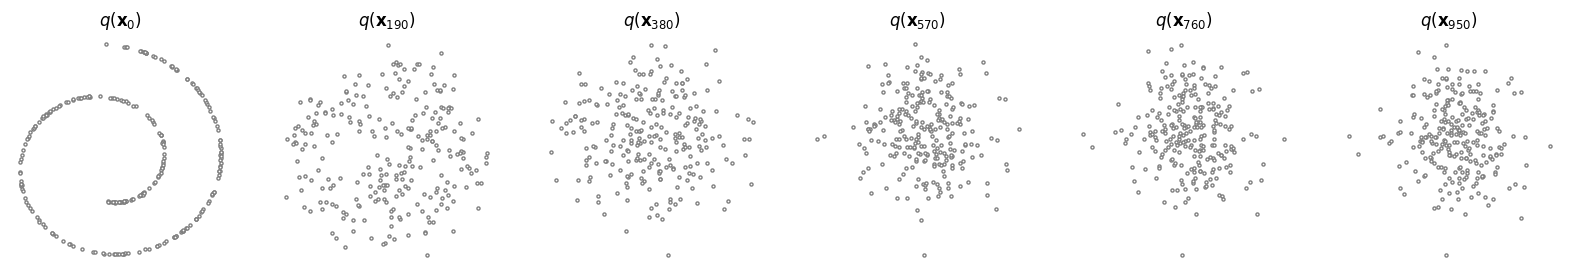

In [9]:
x_0 = next(iter(val_dataloader))
x_0 = x_0.to(device)
x_t_list = []
common_noise = torch.randn_like(x_0)

fig, axs = plt.subplots(1, 6, figsize=(20, 3))
for i, t in enumerate(range(0, 1000, 190)):
    t_ = torch.full((x_0.shape[0],), t, device=device)
    x_t = forward_diffusion(x_0, t_, noise_schedule, noise=common_noise)[0]
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,1], color='white', edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title('$q(\mathbf{x}_{'+str(t)+'})$')

As the noise increases, the orderly spiral quickly fades away as it becomes a disordered pile of points.

## Reverse Denoising

Reverse denoising uses a trained denoising model to incremenetally remove noise from an image. We'll define the denoising step for this process now, but before we can use it, we'll need to train a model.

In [16]:
def denoising_step(denoising_model, x_t, t, noise_schedule, thresholding=False):
    """
    This is the backward diffusion step, with the effect of denoising.
    """
    if isinstance(t, int):
        t_tensor = torch.full((x_t.shape[0],), t, device=x_t.device)
    else:
        t_tensor = t
    with torch.no_grad():
        model_output = denoising_model(t=t_tensor, x=x_t)
    if hasattr(model_output, "sample"):
        model_output = model_output.sample

    # Extract relevant values from noise_schedule
    alpha_prod_t = noise_schedule["alphas_cumprod"][t_tensor]
    # deal with t=0 case where t can be a tensor
    alpha_prod_t_prev = torch.where(t_tensor > 0,
                                    noise_schedule["alphas_cumprod"][t_tensor - 1],
                                    torch.ones_like(t_tensor, device=x_t.device))

    # Reshape alpha_prod_t_prev for proper broadcasting
    view_shape = (-1,) + (1,) * (x_t.ndim - 1)
    alpha_prod_t = alpha_prod_t.view(*view_shape)
    alpha_prod_t_prev = alpha_prod_t_prev.view(*view_shape)

    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t

    # Compute the previous sample mean
    pred_original_sample = (x_t - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

    # Compute the coefficients for pred_original_sample and current sample
    pred_original_sample_coeff = (alpha_prod_t_prev ** 0.5 * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** 0.5 * beta_prod_t_prev / beta_prod_t

    # Compute the previous sample
    pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * x_t

    # Add noise
    variance = torch.zeros_like(x_t)
    variance_noise = torch.randn_like(x_t)

    # Handle t=0 case where t can be a tensor
    non_zero_mask = (t_tensor != 0).float().view(view_shape)
    variance = non_zero_mask * ((1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t)
    variance = torch.clamp(variance, min=1e-20)

    pred_prev_sample = pred_prev_sample + (variance ** 0.5) * variance_noise

    return pred_prev_sample


def generate_samples_by_denoising(denoising_model, x_T, noise_schedule, n_T, device, thresholding=False, seed=0):
    """
    This is the generation process.
    """
    torch.manual_seed(seed)

    x_t = x_T.to(device)
    pbar = tqdm(range(n_T - 1, -1, -1))
    for t in pbar:
        x_t = denoising_step(denoising_model, x_t, t, noise_schedule, thresholding)
        pbar.set_postfix({"std": x_t.std().item()})

    # print("raw x_t range", x_t.min(), x_t.max())
    # x_t = (x_t / 2 + 0.5).clamp(0, 1)
    # print("after clamp", x_t.min(), x_t.max())
    return x_t.cpu()

## Training code

We've picked our data, created our dataloaders, and defined our noise schedule, foward diffusion, and reverse diffusion steps. Now, the only thing left to do is to train our diffusion model.

In [17]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, steps: int=100) -> float:
  criterion = MSELoss()
  model.train()
  print("Training on device:", device)
  max_train_steps = steps

  step = 0
  while step < max_train_steps:
    progress_bar = tqdm(train_dataloader)
    for x_0 in progress_bar:
      x_0 = x_0.float().to(device)  # x_0 is the clean data to teach the model to generate
      optimizer.zero_grad()

      true_noise = common_noise = torch.randn(x_0.shape).to(device)
      t = torch.randint(0, config.num_denoising_steps, (x_0.shape[0],), device=device).long()
      x_t, _ = forward_diffusion(x_0, t, noise_schedule, noise=common_noise)

      predicted_noise = model(t=t, x=x_t)

      loss = criterion(predicted_noise, true_noise)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # try commenting it out
      optimizer.step()

      progress_bar.set_postfix({"loss": loss.cpu().item()})

      step += 1

      if step >= max_train_steps:
        print(f"Reached the max training steps:", max_train_steps)
        break

  return loss

# Define the model and optimizer
model3 = Model3(
    dim_in=2,
    dim_out=2,
    hidden_features=[128, 128, 256],
    num_timesteps=config.num_denoising_steps,
).to(device)
print(f"model params: {sum(p.numel() for p in model3.parameters())}")
model3_optimizer = optim.AdamW(model3.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

# Train the model
model3_loss = train(model3, model3_optimizer, steps=100)

model params: 281354
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


# Generation

We trained a model for 100 training steps. Let's see what the output looks like at this early stage.

  0%|          | 0/1000 [00:00<?, ?it/s]

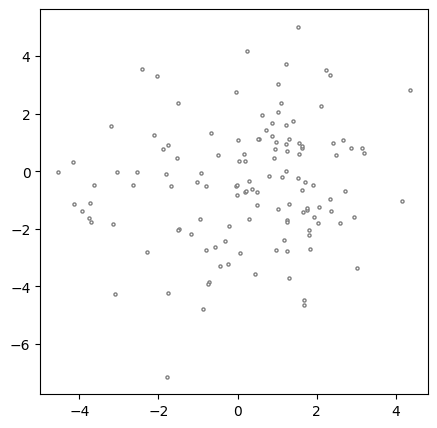

In [18]:
# visualize the sampled images
def visualize_sampled_data(model):
  # print("Loss of the denoising model:", loss.item())
  x_T = torch.randn(128, 2)
  x_sampled = generate_samples_by_denoising(model, x_T, noise_schedule, n_T=1000, device=device).cpu().detach().numpy()

  # plt.scatter(x_sampled[:, 0], x_sampled[:, 1])
  fig, axs = plt.subplots(1, 1, figsize=(5, 5))
  axs.scatter(x_sampled[:,0], x_sampled[:,1], color='white', edgecolor='gray', s=5)
  # axs.set_axis_off()
  # plt.xlim(-3.6, 3.6)
  # plt.ylim(-3.6, 3.6)


visualize_sampled_data(model3)

Still looks like noise. What if we increase the length of training?

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 1000
loss: 0.3751950263977051


  0%|          | 0/1000 [00:00<?, ?it/s]

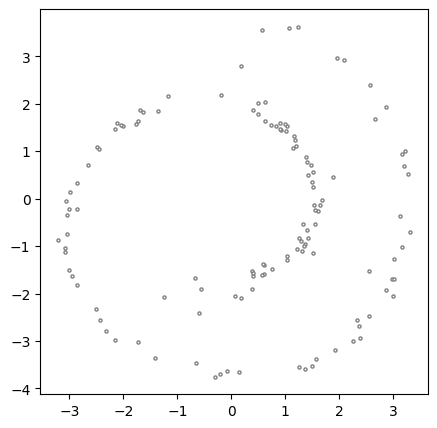

In [19]:
# Train some more
model3_loss = train(model3, model3_optimizer, steps=1000)
print("loss:", model3_loss.item())
visualize_sampled_data(model3)

That's more like it! In just 1000 training steps, we were able to go from complete noise to a fairly representative spiral.

To get a better idea of what the inbetween steps looked like, let's animate the process every 100 steps.

In [20]:
model3 = Model3(
    dim_in=2,
    dim_out=2,
    hidden_features=[128, 128, 256],
    num_timesteps=config.num_denoising_steps,
).to(device)
model3_optimizer = optim.AdamW(model3.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

samples = []
num_samples = 10
for i in range(num_samples):
    model3_loss = train(model3, model3_optimizer, steps=100)
    samples.append(generate_samples_by_denoising(model3, torch.randn(128, 2), noise_schedule, n_T=1000, device=device))


Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 100


  0%|          | 0/1000 [00:00<?, ?it/s]

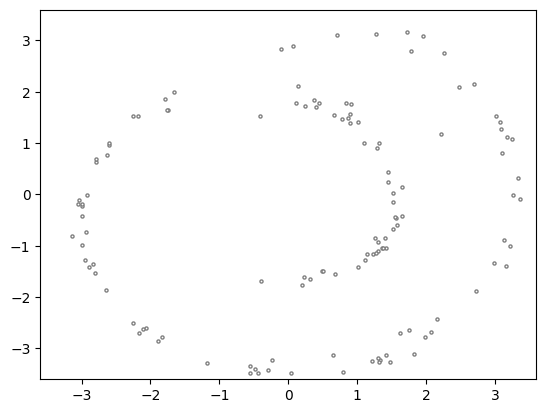

In [21]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
sc = ax.scatter(samples[0][:, 0], samples[0][:, 1], color='white', edgecolor='gray', s=5)
ax.set_xlim(-3.6, 3.6)
ax.set_ylim(-3.6, 3.6)

def update(i):
    sc.set_offsets(samples[i])
    return sc,


ani = animation.FuncAnimation(fig, update, frames=range(num_samples), interval=1000, blit=True)
HTML(ani.to_jshtml())

# Comparing Model Performance

To compare the quality of different model architectures at generating 2D spirals, we can use the Chamfer distance. The Chamfer distance is an evaluation metric for comparing two point clouds, so it's perfect for our data.

In [22]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def chamfer_distance(x, y, metric='l2', direction='bi'):
    """Chamfer distance between two point clouds

    Parameters
    ----------
    x: numpy array [n_points_x, n_dims]
        first point cloud
    y: numpy array [n_points_y, n_dims]
        second point cloud
    metric: string or callable, default ‘l2’
        metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.
    direction: str
        direction of Chamfer distance.
            'y_to_x':  computes average minimal distance from every point in y to x
            'x_to_y':  computes average minimal distance from every point in x to y
            'bi': compute both
    Returns
    -------
    chamfer_dist: float
        computed bidirectional Chamfer distance:
            sum_{x_i \in x}{\min_{y_j \in y}{||x_i-y_j||**2}} + sum_{y_j \in y}{\min_{x_i \in x}{||x_i-y_j||**2}}
    """
    
    if direction=='y_to_x':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        chamfer_dist = np.mean(min_y_to_x)
    elif direction=='x_to_y':
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_x_to_y)
    elif direction=='bi':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_y_to_x) + np.mean(min_x_to_y)
    else:
        raise ValueError("Invalid direction type. Supported types: \'y_x\', \'x_y\', \'bi\'")
        
    return chamfer_dist

# Model 1

model params: 265730
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
model1_loss: 0.36153721809387207


  0%|          | 0/1000 [00:00<?, ?it/s]

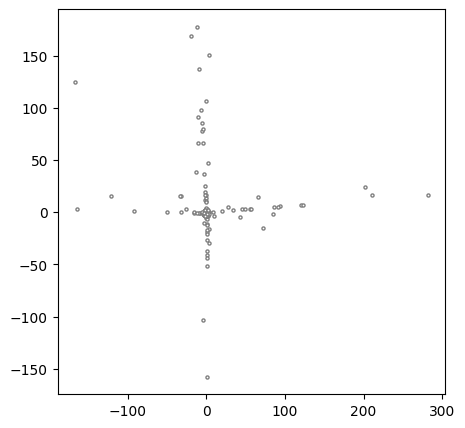

In [23]:
model1 = Model1(hidden_features=[512, 512]).to(device)
print(f"model params: {sum(p.numel() for p in model1.parameters())}")

model1_optimizer = optim.AdamW(model1.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model1_loss = train(model1, model1_optimizer, steps=5000)
print("model1_loss:", model1_loss.item())
visualize_sampled_data(model1)

## Model 2

model params: 281602
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
model2_loss: 0.39942044019699097


  0%|          | 0/1000 [00:00<?, ?it/s]

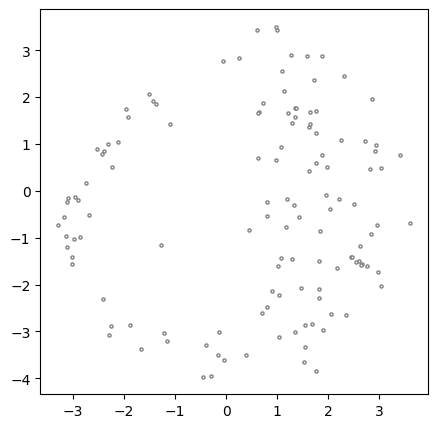

In [24]:
model2 = Model2(features=2, hidden_features=[512, 512]).to(device)
print(f"model params: {sum(p.numel() for p in model2.parameters())}")

model2_optimizer = optim.AdamW(model2.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model2_loss = train(model2, model2_optimizer, steps=5000)
print("model2_loss:", model2_loss.item())
visualize_sampled_data(model2)

## Model 3

model params: 1054218
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
model3_loss: 0.38134822249412537


  0%|          | 0/1000 [00:00<?, ?it/s]

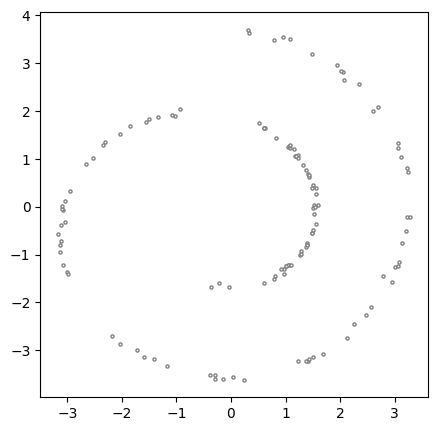

In [25]:
model3 = Model3(
    dim_in=2,
    dim_out=2,
    hidden_features=[512, 512],
    num_timesteps=config.num_denoising_steps,
).to(device)
print(f"model params: {sum(p.numel() for p in model3.parameters())}")

model3_optimizer = optim.AdamW(model3.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
model3_loss = train(model3, model3_optimizer, steps=5000)
print("model3_loss:", model3_loss.item())
visualize_sampled_data(model3)

  0%|          | 0/1000 [00:00<?, ?it/s]

Model 1 Chamfer Distance: 0.786137270565381


  0%|          | 0/1000 [00:00<?, ?it/s]

Model 2 Chamfer Distance: 0.660230517745129


  0%|          | 0/1000 [00:00<?, ?it/s]

Model 3 Chamfer Distance: 0.2207637623034166


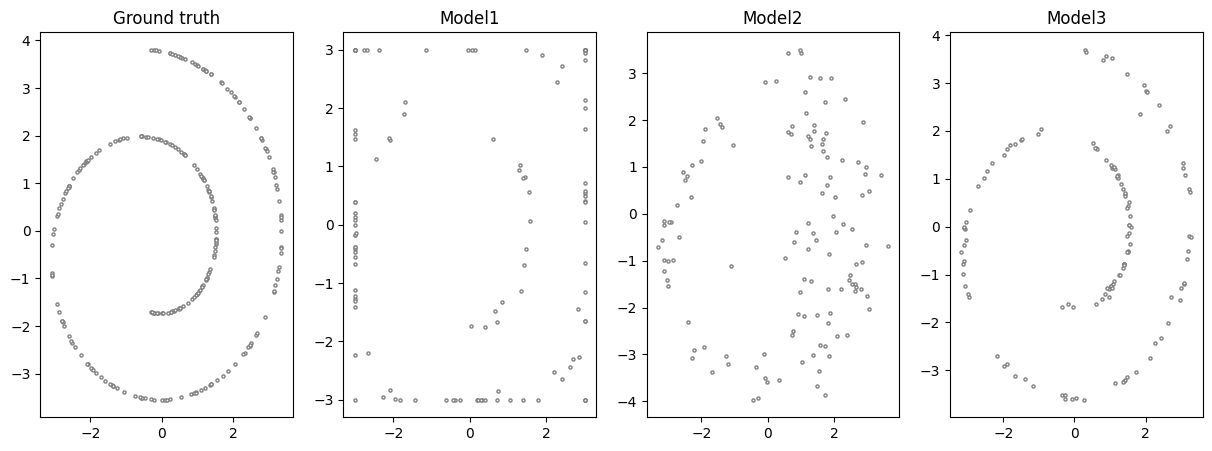

In [26]:
import torch

# Sample points from the model
def generate_points(model):
    with torch.no_grad():
        x_T = torch.randn(128, 2)
        x_sampled = generate_samples_by_denoising(model, x_T, noise_schedule, n_T=1000, device=device)
    return x_sampled.cpu().numpy()


# The target spiral points for comparison
target_spiral = next(iter(train_dataloader))

generated_points_1 = generate_points(model1)
generated_points_1 = np.clip(generated_points_1, -3, 3)
chamfer_dist = chamfer_distance(generated_points_1, target_spiral, direction='bi')
print("Model 1 Chamfer Distance:", chamfer_dist)


generated_points_2 = generate_points(model2)
chamfer_dist = chamfer_distance(generated_points_2, target_spiral, direction='bi')
print("Model 2 Chamfer Distance:", chamfer_dist)

# Calculate Chamfer distance
generated_points_3 = generate_points(model3)
chamfer_dist = chamfer_distance(generated_points_3, target_spiral, direction='bi')
print("Model 3 Chamfer Distance:", chamfer_dist)

# # visualize the sampled images side by side
def visualize_sampled_data_side_by_side(models, generated_points):
    fig, axs = plt.subplots(1, len(models) + 1, figsize=(5 * len(models), 5))
    # Add ground truth
    axs[0].scatter(target_spiral[:, 0], target_spiral[:, 1], color='white', edgecolor='gray', s=5)
    axs[0].set_title("Ground truth")

    for i, (model, points) in enumerate(zip(models, generated_points)):
        axs[i+1].scatter(points[:,0], points[:,1], color='white', edgecolor='gray', s=5)
        axs[i+1].set_title(model.__class__.__name__)

visualize_sampled_data_side_by_side([model1, model2, model3], [generated_points_1, generated_points_2, generated_points_3])

## Learning questions

- [X] Does neural net arch matter for the quality (measured by Chamfer)?
  - Ingredients (which ones are necessary):
    - sine embedding of time t
    - operator for fusing t and x: concat vs. multiply
    - residual connection
  - arch 1, Simple linear (no sine embedding, concat time and x)
  - arch 2, Sine embedding, concat time embedding and x
  - arch 3, TimeLinear (sine embedding, and multiply time embedding with x embedding)
- [ ] How does the model size matter (number of layers, number of hidden units), within the same class of arch?
- [X] What is the history of sine/cosine positional embeddings? We can include some background material about how people came up with this idea.
- [X] Animate the trajectory of forward diffusion, and denoising sampling.
- [X] Animate the learning process, how does trajectories change.

TODO: we could use a for loop to print out chamfer distances.

# Model Hyperparameter Comparison

In [39]:
from dataclasses import dataclass

@dataclass
class ModelConfig:
    model: str
    hidden_features: list[int]
    num_timesteps: int

models = ["model1", "model2", "model3"]
layers = [[512, 512], [256, 256, 256, 256, 256]]
num_timesteps = [1000, 5000, 10000]

model_configs = [
    ModelConfig(model=model, hidden_features=layer, num_timesteps=num_timestep)
    for model in models for layer in layers for num_timestep in num_timesteps
]

In [43]:
losses = []
chamfer_distances = []
target_spiral = next(iter(train_dataloader))
for m_config in model_configs:
    if m_config.model == "model1":
        model = Model1(hidden_features=m_config.hidden_features).to(device)
    elif m_config == "model2":
        model = Model2(features=2, hidden_features=m_config.hidden_features).to(device)
    else:
        model = Model3(
            hidden_features=m_config.hidden_features,
            num_timesteps=m_config.num_timesteps,
        ).to(device)
    print(f"Model: {model}, Layers: {m_config.hidden_features}, Num Timesteps: {m_config.num_timesteps}")
    print(f"model params: {sum(p.numel() for p in model.parameters())}")
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    loss = train(model, optimizer, steps=m_config.num_timesteps)
    print("loss:", loss.item())
    generated_points = generate_points(model)
    chamfer_dist = chamfer_distance(generated_points, target_spiral, direction='bi')
    chamfer_distances.append(chamfer_dist)
    print("Chamfer Distance:", chamfer_dist)


Model: Model1(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
    (5): Tanh()
  )
), Layers: [512, 512], Num Timesteps: 1000
model params: 265730
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 1000
loss: 0.4874815344810486


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 47.81893889858101
Model: Model1(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
    (5): Tanh()
  )
), Layers: [512, 512], Num Timesteps: 5000
model params: 265730
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
loss: 0.36153721809387207


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 35.910285879563126
Model: Model1(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
    (5): Tanh()
  )
), Layers: [512, 512], Num Timesteps: 10000
model params: 265730
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 10000
loss: 0.3560352325439453


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 35.08107325069531
Model: Model1(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=2, bias=True)
    (11): Tanh()
  )
), Layers: [256, 256, 256, 256, 256], Num Timesteps: 1000
model params: 264706
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 1000
loss: 0.46338433027267456


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 45.160042575218306
Model: Model1(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=2, bias=True)
    (11): Tanh()
  )
), Layers: [256, 256, 256, 256, 256], Num Timesteps: 5000
model params: 264706
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
loss: 0.39557987451553345


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 45.67783969131971
Model: Model1(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=2, bias=True)
    (11): Tanh()
  )
), Layers: [256, 256, 256, 256, 256], Num Timesteps: 10000
model params: 264706
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 10000
loss: 0.4173853397369385


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 37.97567627369625
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=2, bias=True)
          (1): SiLU()
          (2): Linear(in_features=2, out_features=2, bi

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 1000
loss: 0.2969387173652649


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.32677761305904257
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=2, bias=True)
          (1): SiLU()
          (2): Linear(in_features=2, out_features=2, 

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
loss: 0.38134822249412537


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.2178648054216687
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=2, bias=True)
          (1): SiLU()
          (2): Linear(in_features=2, out_features=2, b

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 10000
loss: 0.28635868430137634


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.20531250969277606
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 1000
loss: 0.3445849120616913


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.258772333769391
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=2

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
loss: 0.2903587222099304


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.1912896609548167
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 10000
loss: 0.27569061517715454


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.1843092509352006
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=2, bias=True)
          (1): SiLU()
          (2): Linear(in_features=2, out_features=2, b

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 1000
loss: 0.2969387173652649


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.32677761305904257
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=2, bias=True)
          (1): SiLU()
          (2): Linear(in_features=2, out_features=2, 

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
loss: 0.38134822249412537


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.2178648054216687
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (fc): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=2, bias=True)
          (1): SiLU()
          (2): Linear(in_features=2, out_features=2, b

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 10000
loss: 0.28635868430137634


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.20531250969277606
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 1000
loss: 0.3445849120616913


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.258772333769391
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=2

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
loss: 0.2903587222099304


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.1912896609548167
Model: Model3(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 10000
loss: 0.27569061517715454


  0%|          | 0/1000 [00:00<?, ?it/s]

Chamfer Distance: 0.1843092509352006


In [44]:
# Find the best model
best_model_idx = np.argmin(chamfer_distances)

best_model = model_configs[best_model_idx]
print(f"Best model: {best_model}, Chamfer Distance: {chamfer_distances[best_model_idx]}")

Best model: ModelConfig(model='model2', hidden_features=[256, 256, 256, 256, 256], num_timesteps=10000), Chamfer Distance: 0.1843092509352006


Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 10000
loss: 0.2613376975059509


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

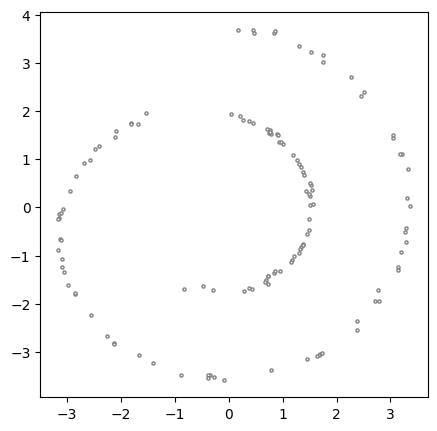

In [45]:
# Generate points
if best_model.model == "model1":
    model = Model1(hidden_features=best_model.hidden_features).to(device)
elif best_model.model == "model2":
    model = Model2(features=2, hidden_features=best_model.hidden_features).to(device)
else:
    model = Model3(
        hidden_features=best_model.hidden_features,
        num_timesteps=best_model.num_timesteps,
    ).to(device)

optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
loss = train(model, optimizer, steps=best_model.num_timesteps)
print("loss:", loss.item())
generated_points = generate_points(model)

# Visualize the best model
visualize_sampled_data(model)
